<a href="https://colab.research.google.com/github/lszam/mineralexp/blob/main/tcc_landsat_3bandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imagens de satélite - mosaico**




# 1. Instalar pacotes no ambiente

In [1]:
!apt-get install -y gdal-bin

!pip install pystac_client planetary_computer rasterio geopandas matplotlib tqdm -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 5,055 kB of archives.
After this operation, 25.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.6.4+dfsg-1~jammy0 [1,027 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.6.4+dfsg-1~jammy0 [561 kB]
Fetched 5,055 kB in 1s (3,711 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 126333 files and direc

Importar pacotes que serão usados

In [2]:
from datetime import datetime
from pystac_client import Client
import planetary_computer as pc
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from shapely.geometry import shape, Polygon
import matplotlib.pyplot as plt

import os
import gc
import requests

from rasterio.warp import calculate_default_transform, reproject#, Resampling
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt
import glob

from rasterio.enums import Resampling

from rasterio.transform import array_bounds
from affine import Affine

# 2. Selecionar imagens

**Escolha aqui as coordenadas da área de interesse, AOI (area of interest)**

In [14]:
# 1. Conectar ao catálogo
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# 2. Definir a área de interesse (AOI)
aoi = {
    "type": "Polygon",
    "coordinates": [[
        [-51.44, -7.42],  # canto sudoeste
        [-48.72, -7.42],  # canto sudeste
        [-48.72, -4.72],  # canto nordeste
        [-51.44, -4.72],  # canto noroeste
        [-51.44, -7.42]   # fechar o polígono
    ]]
}

In [12]:
collections = catalog.get_collections()
for item in collections:
  print(item)

<CollectionClient id=daymet-annual-pr>
<CollectionClient id=daymet-daily-hi>
<CollectionClient id=3dep-seamless>
<CollectionClient id=3dep-lidar-dsm>
<CollectionClient id=fia>
<CollectionClient id=sentinel-1-rtc>
<CollectionClient id=gridmet>
<CollectionClient id=daymet-annual-na>
<CollectionClient id=daymet-monthly-na>
<CollectionClient id=daymet-annual-hi>
<CollectionClient id=daymet-monthly-hi>
<CollectionClient id=daymet-monthly-pr>
<CollectionClient id=gnatsgo-tables>
<CollectionClient id=hgb>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=terraclimate>
<CollectionClient id=nasa-nex-gddp-cmip6>
<CollectionClient id=gpm-imerg-hhr>
<CollectionClient id=gnatsgo-rasters>
<CollectionClient id=3dep-lidar-hag>
<CollectionClient id=io-lulc-annual-v02>
<CollectionClient id=goes-cmi>
<CollectionClient id=conus404>
<CollectionClient id=3dep-lidar-intensity>
<CollectionClient id=3dep-lidar-pointsourceid>
<CollectionClient id=mtbs>
<CollectionCli

Existem 52 imagens pré-selecionadas


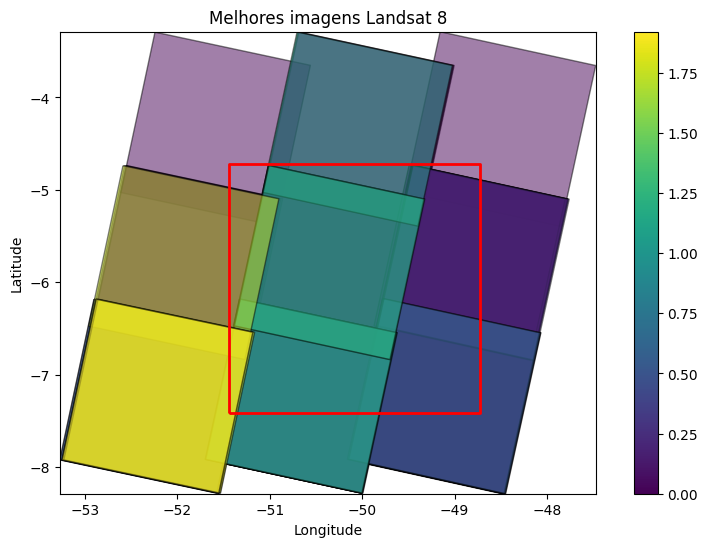

In [17]:
# 3. Buscar imagens Landsat 8 (filtro nuvens e data)
search = catalog.search(
    filter_lang="cql2-json",
    filter={
        "op": "and",
        "args": [
            {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
            {"op": "<", "args": [{"property": "eo:cloud_cover"}, 2]}, # 👈 escolher % de nuvens
            {"op": "=", "args": [{"property": "collection"}, "landsat-8-c2-l2"]}, # 👈 escolher LANDSAT
            {"op": ">", "args": [{"property": "datetime"}, "2020-01-01T00:00:00Z"]},
            {"op": "<", "args": [{"property": "datetime"}, "2022-01-01T23:59:59Z"]}
        ]
    }
)

# 4. Obter e ordenar por menor cobertura de nuvem
items = list(search.items())
items_sorted = sorted(items, key=lambda item: item.properties.get("eo:cloud_cover", 100))

# 5. Selecionar as melhores
best_items = items_sorted[:100] # 👈 escolher número de imagens listadas

print(f"Existem {len(best_items)} imagens pré-selecionadas")

# 6. Gerar GeoDataFrame dos footprints
geoms = [shape(item.geometry) for item in best_items]
gdf = gpd.GeoDataFrame({
    "cloud_cover": [item.properties["eo:cloud_cover"] for item in best_items],
    "datetime": [item.properties["datetime"] for item in best_items]
}, geometry=geoms, crs="EPSG:4326")

# 7. AOI como GeoDataFrame
aoi_geom = Polygon(aoi['coordinates'][0])
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geom], crs="EPSG:4326")

# 8. Plotar localização das imagens encontradas, cores para o "cloud_cover"
fig, ax = plt.subplots(figsize=(10, 6))
# Localização das imagens
gdf.plot(ax=ax, column="cloud_cover", legend=True, cmap="viridis", alpha=0.5, edgecolor='black')
# Plotar a área de interesse (AOI)
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
# Definir os limites do gráfico manualmente com base na geometria
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')

plt.title("Melhores imagens Landsat 8")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()




Verificar como as imagens se sobrepõem para evitar redundância

In [18]:
# Reprojetar para UTM 23S (projeção métrica em metros)
gdf_proj = gdf.to_crs("EPSG:31983")

# Calcular área no CRS projetado (em m²)
gdf_proj["area"] = gdf_proj.geometry.area

# Identificar quais imagens manter
keep_indexes = []

for i, geom_i in enumerate(gdf_proj.geometry):
    to_keep = True
    for j in range(i):
        geom_j = gdf_proj.geometry[j]
        intersection = geom_i.intersection(geom_j)
        if intersection.is_empty:
            continue
        overlap_ratio = intersection.area / geom_i.area
        if overlap_ratio > 0.50:  # 👈 escolher taxa de sobreposição
            to_keep = False
            break
    if to_keep:
        keep_indexes.append(i)

# Filtrar as imagens não redundantes
gdf_reduzido = gdf.iloc[keep_indexes].copy()
print(f"{len(gdf_reduzido)} imagens mantidas de {len(gdf)} após remover sobreposições")
print("\nVariável gdf_reduzido:\n", gdf_reduzido)


# Garantir que o GeoDataFrame das imagens reduzidas está no mesmo CRS da AOI
gdf_reduzido = gdf_reduzido.to_crs("EPSG:4326")
aoi_gdf = aoi_gdf.to_crs("EPSG:4326")


9 imagens mantidas de 52 após remover sobreposições

Variável gdf_reduzido:
     cloud_cover                     datetime  \
0           0.0  2021-08-09T13:30:59.197194Z   
1           0.0  2021-08-09T13:30:35.272267Z   
2           0.0  2021-07-15T13:36:57.669471Z   
3           0.0  2021-07-01T13:24:35.281948Z   
4           0.0  2021-07-01T13:24:11.357021Z   
9           0.0  2020-08-06T13:30:02.341880Z   
12          0.0  2020-07-28T13:36:35.285419Z   
13          0.0  2020-07-28T13:36:11.364727Z   
16          0.0  2020-07-14T13:23:45.715309Z   

                                             geometry  
0   POLYGON ((-51.32354 -6.18304, -49.62972 -6.545...  
1   POLYGON ((-51.01035 -4.73693, -49.32288 -5.099...  
2   POLYGON ((-52.86326 -6.18339, -51.16844 -6.541...  
3   POLYGON ((-49.78404 -6.17829, -48.08872 -6.547...  
4   POLYGON ((-49.47255 -4.73324, -47.78299 -5.100...  
9   POLYGON ((-50.68619 -3.29126, -49.00415 -3.653...  
12  POLYGON ((-52.55578 -4.73808, -50.86815 -5.097

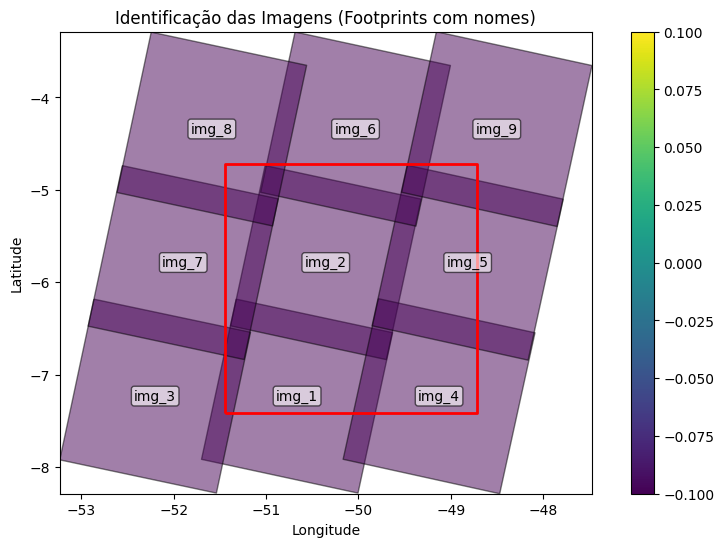

In [20]:
# Plotar os footprints mantidos

gdf_reduzido["filename"] = [f"img_{i+1}" for i in range(len(gdf_reduzido))]

fig, ax = plt.subplots(figsize=(10, 6))

gdf_reduzido.plot(ax=ax, column="cloud_cover", legend=True, cmap="viridis", alpha=0.5, edgecolor='black')
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

for idx, row in gdf_reduzido.iterrows():
    centroid = row.geometry.centroid
    label = row["filename"]
    ax.text(centroid.x, centroid.y, label, fontsize=10, ha='center', va='center', color='black',
            bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2'))

xmin, ymin, xmax, ymax = gdf_reduzido.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')

plt.title("Identificação das Imagens (Footprints com nomes)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# 3. Baixar imagens selecionadas

In [21]:
# Exibir bandas das imagens listadas em gdf_reduzido
gdf_reduzido = gdf_reduzido.reset_index(drop=True)

for idx, row in gdf_reduzido.iterrows():
    item = best_items[ keep_indexes[idx] ]
    print(f"Bandas disponíveis para a imagem {row['filename']}:")
    for key, asset in item.assets.items():
        print(f"- {key}: {asset.href}")

Bandas disponíveis para a imagem img_1:
- ANG: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/224/065/LC08_L2SP_224065_20210809_20210819_02_T1/LC08_L2SP_224065_20210809_20210819_02_T1_ANG.txt
- SR_B1: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/224/065/LC08_L2SP_224065_20210809_20210819_02_T1/LC08_L2SP_224065_20210809_20210819_02_T1_SR_B1.TIF
- SR_B2: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/224/065/LC08_L2SP_224065_20210809_20210819_02_T1/LC08_L2SP_224065_20210809_20210819_02_T1_SR_B2.TIF
- SR_B3: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/224/065/LC08_L2SP_224065_20210809_20210819_02_T1/LC08_L2SP_224065_20210809_20210819_02_T1_SR_B3.TIF
- SR_B4: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/224/065/LC08_L2SP_224065_20210809_20210819_02_T1/LC08_L2SP_224065_20210809_20210819_02_T1

Com a lista de bandas em mãos, definimos quais bandas serão baixadas

In [9]:
# Baixar itens
band_list = ["SR_B4","SR_B3","SR_B2"] # 👈 BANDAS ESCOLHIDAS

In [22]:
# Pasta para salvar os arquivos
os.makedirs("/content/landsat", exist_ok=True)

# ===================== Baixar os itens de gdf_reduzido =====================

# Padronizar as datas para comparar imagens da mesma época
# compara datas (dia, mês, ano)
dates_reduzidas = {
    pd.to_datetime(dt).date()
    for dt in gdf_reduzido["datetime"]
}

# filtrar itens cuja data (sem hora) esteja no conjunto
selected_items = [
    item for item in best_items
    if pd.to_datetime(item.properties["datetime"]).date() in dates_reduzidas
]

for i, item in enumerate(selected_items):
    signed = pc.sign_item(item)
    for band_name, asset in signed.assets.items():
        if band_name in band_list:
            url = asset.href
            out_path = f"/content/landsat/img_{i+1}_{band_name}.tif"
            if not os.path.exists(out_path):
                print(f"Baixando {band_name} da imagem {i+1}...")
                r = requests.get(url, stream=True)
                with open(out_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)


Baixando SR_B3 da imagem 2...
Baixando SR_B4 da imagem 2...
Baixando SR_B2 da imagem 3...
Baixando SR_B3 da imagem 3...
Baixando SR_B4 da imagem 3...
Baixando SR_B2 da imagem 4...
Baixando SR_B3 da imagem 4...
Baixando SR_B4 da imagem 4...
Baixando SR_B2 da imagem 5...
Baixando SR_B3 da imagem 5...
Baixando SR_B4 da imagem 5...
Baixando SR_B2 da imagem 6...
Baixando SR_B3 da imagem 6...
Baixando SR_B4 da imagem 6...
Baixando SR_B2 da imagem 7...
Baixando SR_B3 da imagem 7...
Baixando SR_B4 da imagem 7...
Baixando SR_B2 da imagem 8...
Baixando SR_B3 da imagem 8...
Baixando SR_B4 da imagem 8...
Baixando SR_B2 da imagem 9...
Baixando SR_B3 da imagem 9...
Baixando SR_B4 da imagem 9...
Baixando SR_B2 da imagem 10...
Baixando SR_B3 da imagem 10...
Baixando SR_B4 da imagem 10...
Baixando SR_B2 da imagem 11...
Baixando SR_B3 da imagem 11...
Baixando SR_B4 da imagem 11...
Baixando SR_B2 da imagem 12...
Baixando SR_B3 da imagem 12...
Baixando SR_B4 da imagem 12...
Baixando SR_B2 da imagem 13...


Exibindo /content/landsat/img_3_SR_B4.tif...


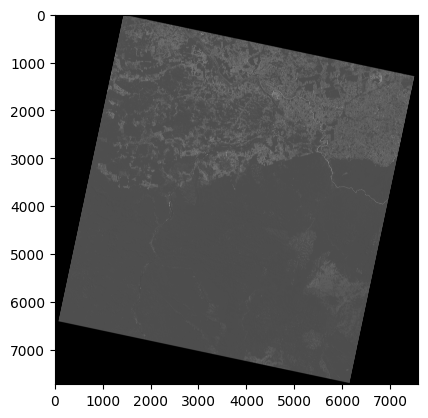

Exibindo /content/landsat/img_11_SR_B3.tif...


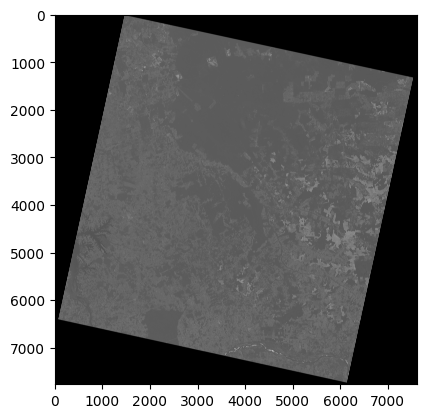

Exibindo /content/landsat/img_14_SR_B2.tif...


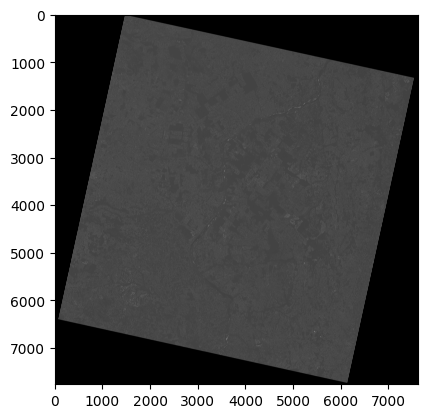

Exibindo /content/landsat/img_4_SR_B3.tif...


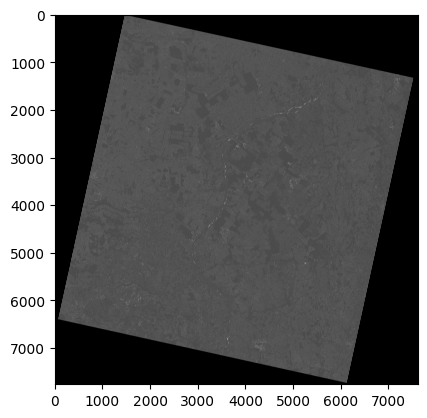

Exibindo /content/landsat/img_14_SR_B3.tif...


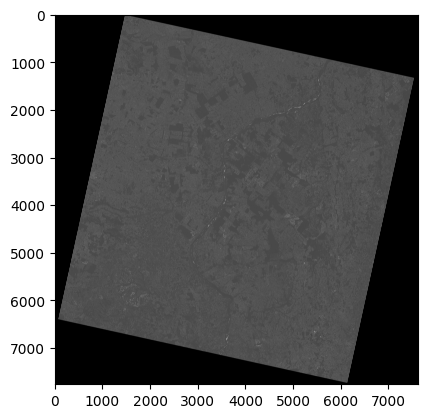

Exibindo /content/landsat/img_14_SR_B4.tif...


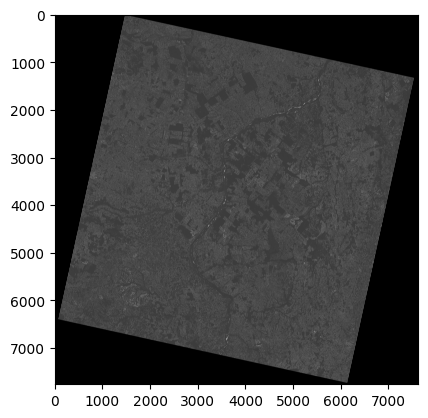

Exibindo /content/landsat/img_8_SR_B3.tif...


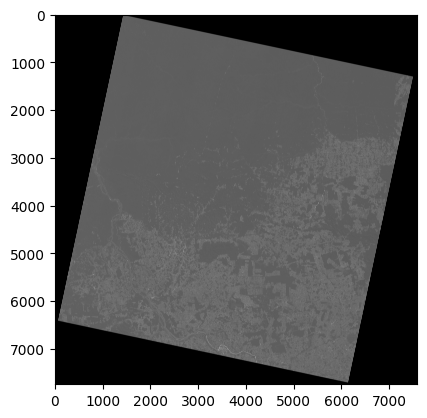

Exibindo /content/landsat/img_10_SR_B2.tif...


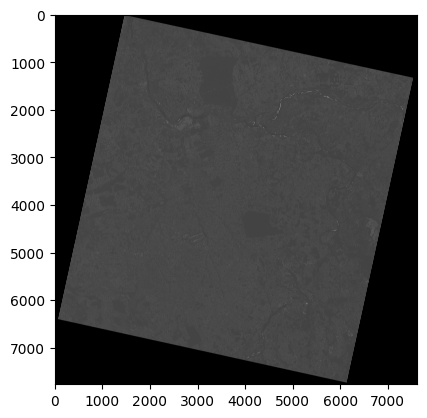

Exibindo /content/landsat/img_13_SR_B3.tif...


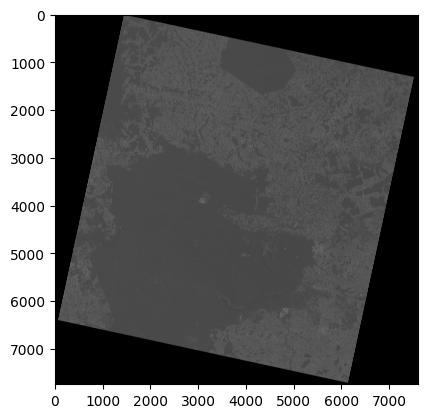

Exibindo /content/landsat/img_10_SR_B3.tif...


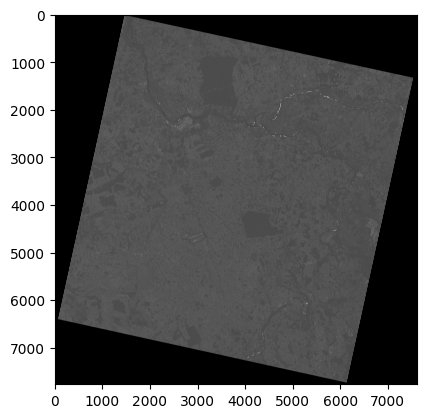

Exibindo /content/landsat/img_3_SR_B2.tif...


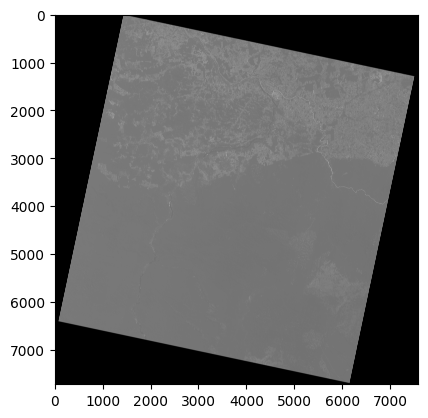

Exibindo /content/landsat/img_6_SR_B2.tif...


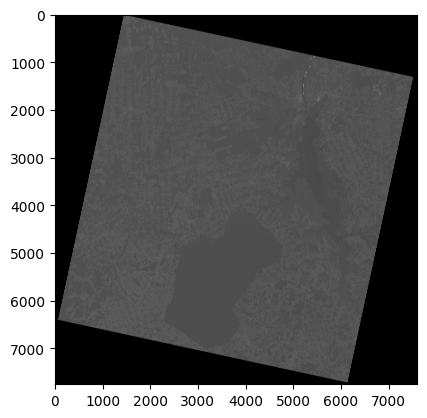

Exibindo /content/landsat/img_2_SR_B4.tif...


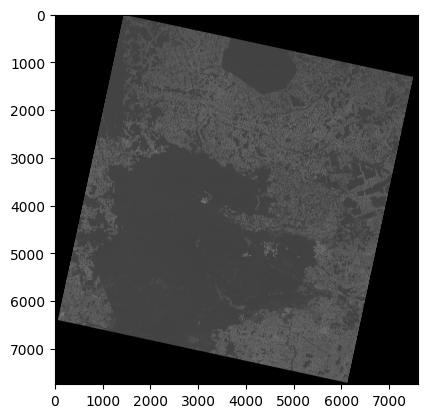

Exibindo /content/landsat/img_4_SR_B4.tif...


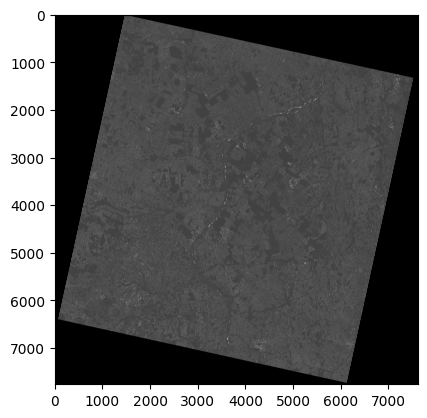

Exibindo /content/landsat/img_12_SR_B3.tif...


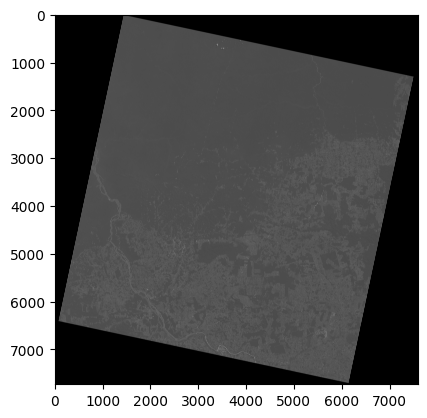

Exibindo /content/landsat/img_1_SR_B3.tif...


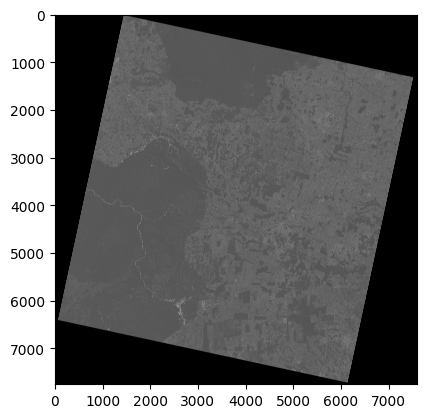

Exibindo /content/landsat/img_2_SR_B3.tif...


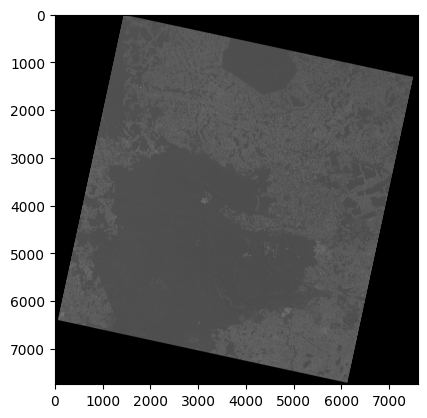

Exibindo /content/landsat/img_9_SR_B2.tif...


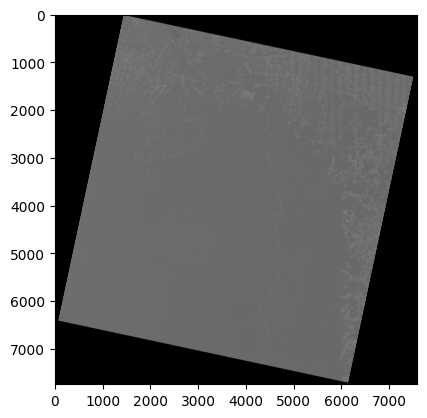

Exibindo /content/landsat/img_5_SR_B4.tif...


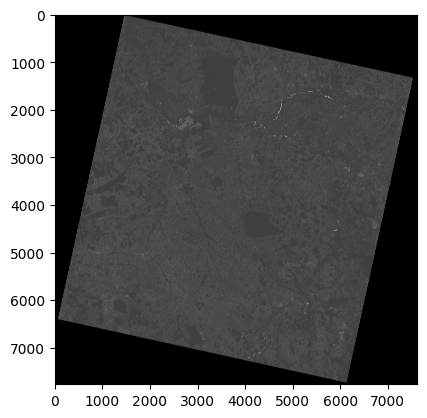

Exibindo /content/landsat/img_11_SR_B4.tif...


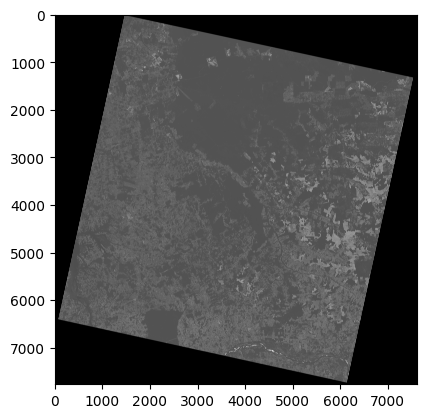

Exibindo /content/landsat/img_3_SR_B3.tif...


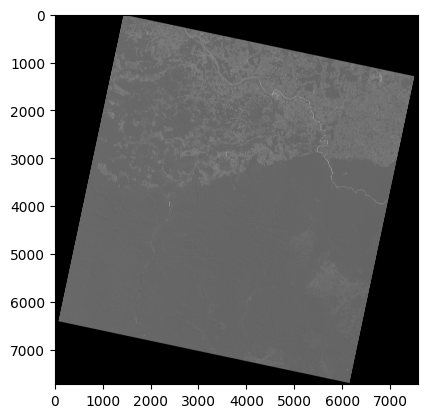

Exibindo /content/landsat/img_4_SR_B2.tif...


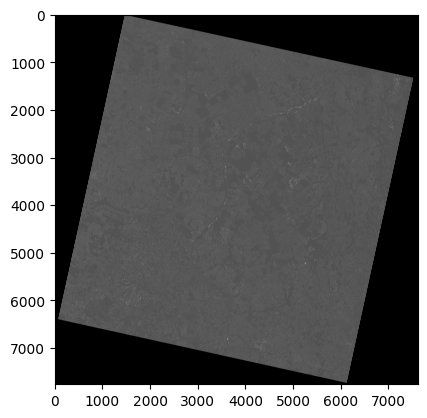

Exibindo /content/landsat/img_6_SR_B4.tif...


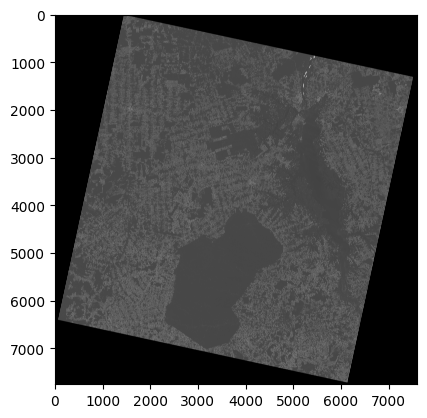

Exibindo /content/landsat/img_7_SR_B2.tif...


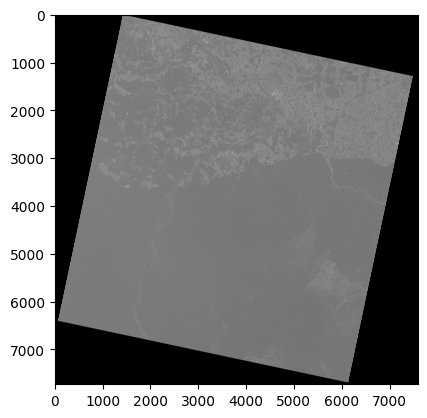

Exibindo /content/landsat/img_15_SR_B4.tif...


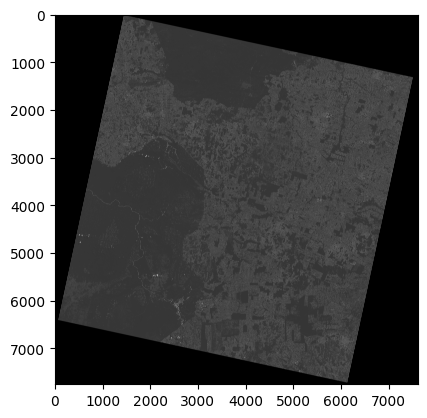

Exibindo /content/landsat/img_1_SR_B2.tif...


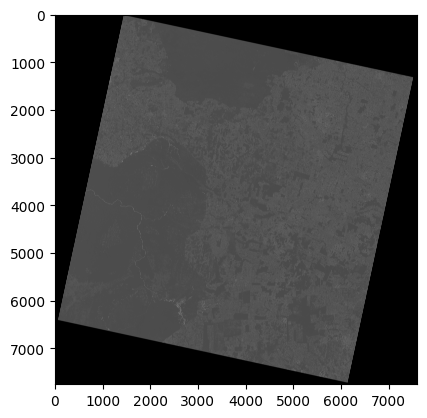

Exibindo /content/landsat/img_10_SR_B4.tif...


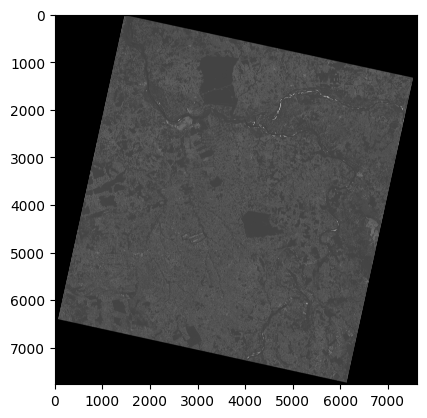

Exibindo /content/landsat/img_13_SR_B2.tif...


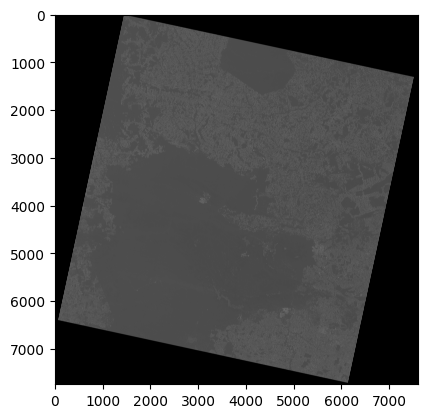

Exibindo /content/landsat/img_5_SR_B2.tif...


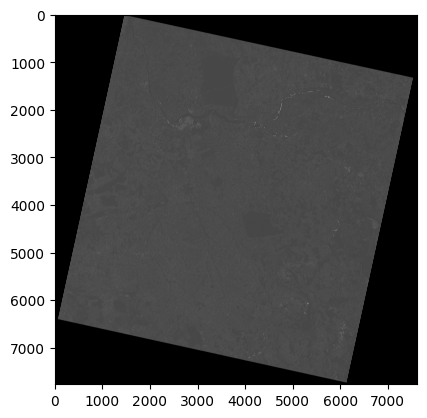

Exibindo /content/landsat/img_8_SR_B4.tif...


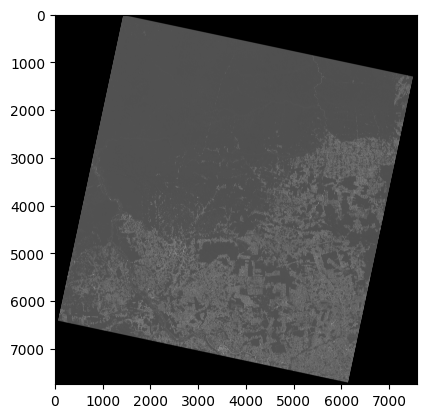

Exibindo /content/landsat/img_12_SR_B4.tif...


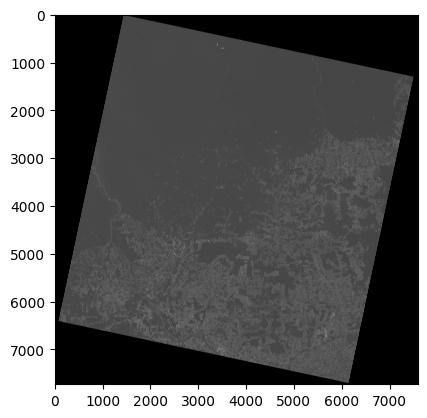

Exibindo /content/landsat/img_15_SR_B2.tif...


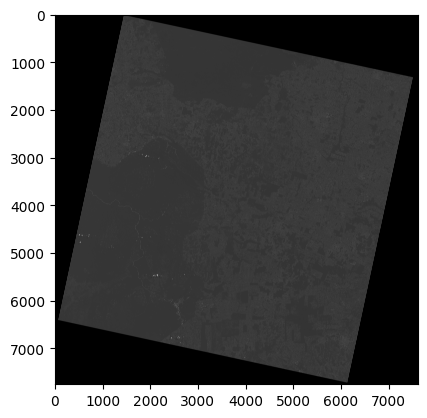

Exibindo /content/landsat/img_11_SR_B2.tif...


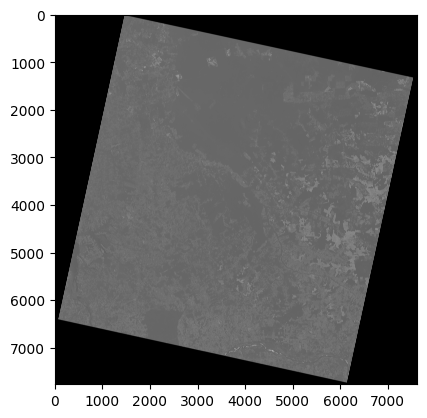

Exibindo /content/landsat/img_7_SR_B3.tif...


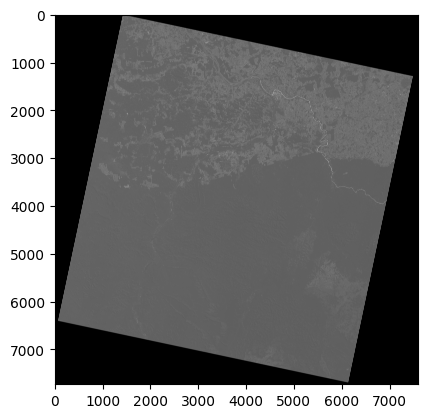

Exibindo /content/landsat/img_13_SR_B4.tif...


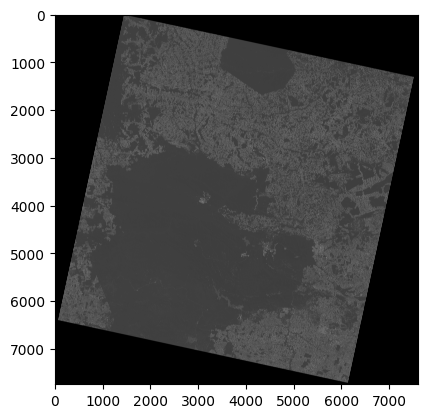

Exibindo /content/landsat/img_9_SR_B4.tif...


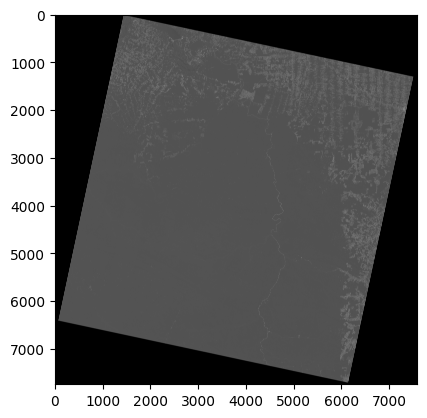

Exibindo /content/landsat/img_1_SR_B4.tif...


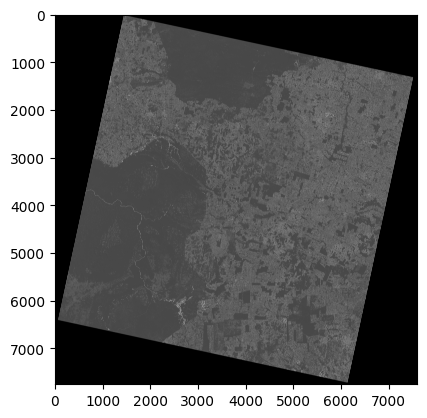

Exibindo /content/landsat/img_15_SR_B3.tif...


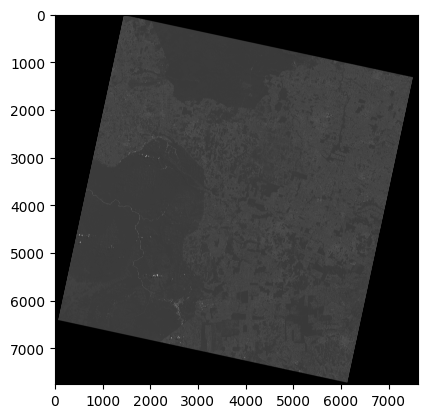

Exibindo /content/landsat/img_9_SR_B3.tif...


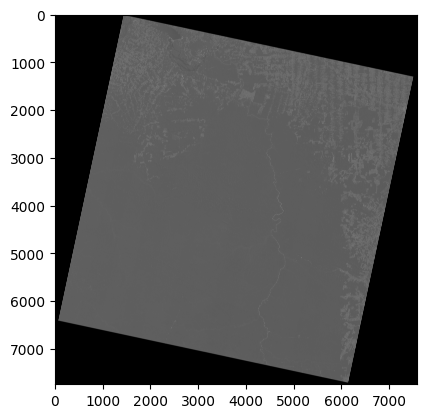

Exibindo /content/landsat/img_5_SR_B3.tif...


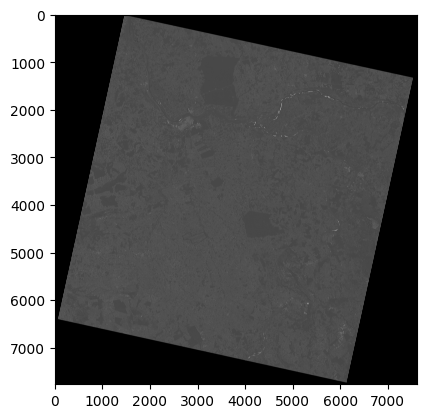

Exibindo /content/landsat/img_6_SR_B3.tif...


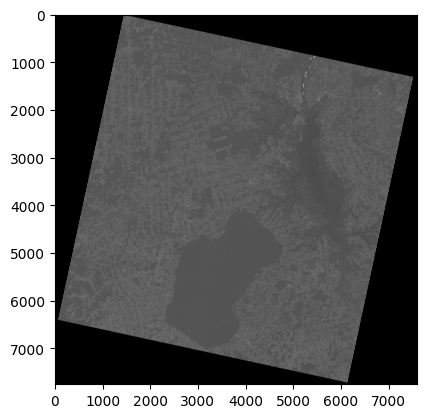

Exibindo /content/landsat/img_12_SR_B2.tif...


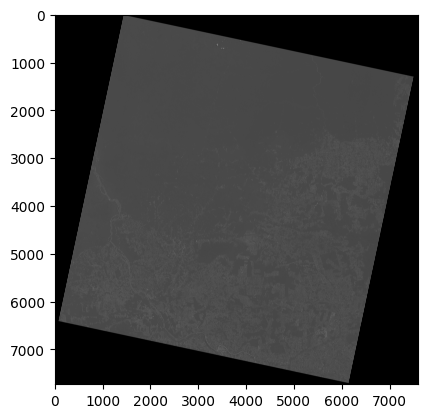

Erro na exibição de /content/landsat/img_2_SR_B2.tif: Read failed. See previous exception for details.
Exibindo /content/landsat/img_8_SR_B2.tif...


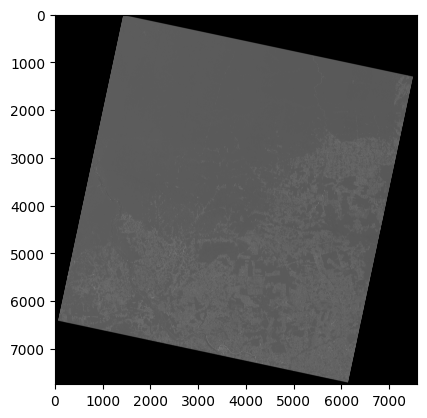

Exibindo /content/landsat/img_7_SR_B4.tif...


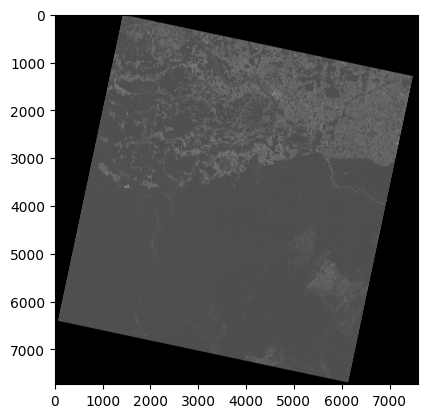

In [23]:
# Exibir imagens selecionadas e baixadas
from rasterio.plot import show

image_files = glob.glob("/content/landsat/*.tif")

for image_file in image_files:
    try:
        with rasterio.open(image_file) as src:
            image = src.read(1)  # 👈 lendo a primeira banda (única, neste caso!)
            print(f"Exibindo {image_file}...")
            show(image, cmap='gray')
    except Exception as e:
        print(f"Erro na exibição de {image_file}: {e}")


# 4. Mosaico

## 4.1 Harmonizar CRSs e fazer um primeiro mosaico


Reprojetar as imagens para um mesmo CRS

In [26]:
reproj_crs = "EPSG:31982"  # CRS para reprojetar para UTM22S/Sirgas2000

images = sorted(glob.glob(f"/content/landsat/*.tif"))

for img_path in images:
  with rasterio.open(img_path) as src:
        print(f"CRS atual de {os.path.basename(img_path)} → {src.crs}")
        if src.crs == reproj_crs:
            continue
        else:
            print(f"Reprojetando {os.path.basename(img_path)} para {reproj_crs}...")

            transform, width, height = calculate_default_transform(
                src.crs, reproj_crs, src.width, src.height, *src.bounds
            )
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': reproj_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(img_path, 'w', **kwargs) as reproj_img:
              try:
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(reproj_img, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    reproj_transform=transform,
                    reproj_crs=reproj_crs,
                    resampling=Resampling.nearest
                )
              except:
                  print(f"Erro ao reprojetar {os.path.basename(img_path)}")
                  continue


CRS atual de img_10_SR_B2.tif → EPSG:31982
CRS atual de img_10_SR_B3.tif → EPSG:31982
CRS atual de img_10_SR_B4.tif → EPSG:31982
CRS atual de img_11_SR_B2.tif → EPSG:31982
CRS atual de img_11_SR_B3.tif → EPSG:31982
CRS atual de img_11_SR_B4.tif → EPSG:31982
CRS atual de img_12_SR_B2.tif → EPSG:31982
CRS atual de img_12_SR_B3.tif → EPSG:31982
CRS atual de img_12_SR_B4.tif → EPSG:31982
CRS atual de img_13_SR_B2.tif → EPSG:31982
CRS atual de img_13_SR_B3.tif → EPSG:31982
CRS atual de img_13_SR_B4.tif → EPSG:31982
CRS atual de img_14_SR_B2.tif → EPSG:31982
CRS atual de img_14_SR_B3.tif → EPSG:31982
CRS atual de img_14_SR_B4.tif → EPSG:31982
CRS atual de img_15_SR_B2.tif → EPSG:31982
CRS atual de img_15_SR_B3.tif → EPSG:31982
CRS atual de img_15_SR_B4.tif → EPSG:31982
CRS atual de img_1_SR_B2.tif → EPSG:31982
CRS atual de img_1_SR_B3.tif → EPSG:31982
CRS atual de img_1_SR_B4.tif → EPSG:31982
CRS atual de img_2_SR_B2.tif → EPSG:31982
CRS atual de img_2_SR_B3.tif → EPSG:32622
Reprojetando img

## 4.2 Fazer o mosaico com correção de histograma

Diferenças de luminosidade entre as imagens são comuns. Estas são o resultado de níveis diferentes de refletância dos objetos presentes nas imagens. Isso pode acontecer por diferenças na iluminação solar (data/hora), ângulo do sensor, atmosfera (mesmo com correção), ou ser algum efeito gerado por diferenças radiométricas, por exemplo.

Por isso, é feita uma correção que elimina valores extremos das imagens, em busca de melhorar a "harmonia" entre estas imagens.

Aqui são demonstradas duas formas de realizar esta correção. A primeira, busca valores extremos a partir do conjunto de imagens. Já a segunda, corrige os valores extremos de cada imagem, para depois mosaicar.

Ao final, observamos qual mosaico mostra menos diferenças de luminosidade.

### 4.2.1 📈 "Strech" da imagem usando valores globais para equilibrar os tons de cinza
**Aplicar correção por "stretch" de valores dentro de um intervalo (percentil 2-98). Aplicado nos arquivos de imagens reprojetados, usando valores globais para equilibrar os tons de cinza**

Calcular os percentis globais de cada banda escolhida anteriormente

In [ ]:
import os

# CALCULAR PERCENTIS GLOBAIS
perc_global = {}
for banda in band_list:
    # Filtrar apenas os TIFFs desta banda
    img_paths = sorted(glob.glob(f"/content/landsat/*{banda}.tif"))
    if not img_paths:
        print(f">>> Atenção! Nenhuma imagem encontrada para a banda {banda}")
        continue

    # Extrair os valores válidos
    all_valid_values = []
    for path in img_paths:
        with rasterio.open(path) as src:
            arr = src.read(1).astype("float32")
            valid = arr[np.isfinite(arr) & (arr > 0)]
            all_valid_values.append(valid)

    all_values = np.concatenate(all_valid_values)
    p2, p98 = np.percentile(all_values, (2, 98))

    #print(f"Percentis para a banda {banda}: P2 = {p2:.2f}, P98 = {p98:.2f}")

    perc_global[banda] = (float(p2), float(p98))


# Aplicar a correção por percentis e salvar TIFFs corrigidos
output_folder = "/content/landsat_stretched_global"
os.makedirs(output_folder, exist_ok=True)

for banda in band_list:
  p2, p98 = perc_global[banda]
  print(f"Banda {banda}")
  img_paths = sorted(glob.glob(f"/content/landsat/*{banda}.tif"))
  print("Arquivos: ", img_paths)
  print(f"Percentis para a banda {banda}: P2 = {p2:.2f}, P98 = {p98:.2f}")
  # itera e faz o stretch
  for path in img_paths:
      with rasterio.open(path) as src:
          data = src.read(1).astype("float32")
          stretched = np.clip((data - p2) / (p98 - p2), 0, 1)
          # copia e atualiza metadados
          meta = src.meta.copy()
          meta.update({
              "dtype": "float32",
              "count": 1,
              "nodata": src.nodata
          })
          # caminho de saída
          out_path = os.path.join(output_folder, os.path.basename(path).replace(".tif", "_stretched.tif"))
          with rasterio.open(out_path, "w", **meta) as src2:
              src2.write(stretched, 1)
          print(f"  → Arquivo salvo: {out_path}")

Banda SR_B4
Arquivos:  ['/content/landsat/img_10_SR_B4.tif', '/content/landsat/img_11_SR_B4.tif', '/content/landsat/img_12_SR_B4.tif', '/content/landsat/img_13_SR_B4.tif', '/content/landsat/img_14_SR_B4.tif', '/content/landsat/img_15_SR_B4.tif', '/content/landsat/img_1_SR_B4.tif', '/content/landsat/img_2_SR_B4.tif', '/content/landsat/img_3_SR_B4.tif', '/content/landsat/img_4_SR_B4.tif', '/content/landsat/img_5_SR_B4.tif', '/content/landsat/img_6_SR_B4.tif', '/content/landsat/img_7_SR_B4.tif', '/content/landsat/img_8_SR_B4.tif', '/content/landsat/img_9_SR_B4.tif']
Percentis para a banda SR_B4: P2 = 7811.00, P98 = 12048.00
  → Arquivo salvo: /content/landsat_stretched_global/img_10_SR_B4_stretched.tif
  → Arquivo salvo: /content/landsat_stretched_global/img_11_SR_B4_stretched.tif
  → Arquivo salvo: /content/landsat_stretched_global/img_12_SR_B4_stretched.tif
  → Arquivo salvo: /content/landsat_stretched_global/img_13_SR_B4_stretched.tif


🪄 **Fazer o mosaico**

In [ ]:
print("\nMosaico:")
for banda in band_list:
    print(f'Banda {banda}')
    # Busca os TIFFs corrigidos da banda
    img_paths = sorted(glob.glob(f"/content/landsat_stretched_global/*{banda}*_stretched.tif"))
    print(img_paths)
    # Pular se só houver 1 arquivo ou menos na lista
    if len(img_paths) < 2:
        print("  >>> Erro, pulando mosaico.")
        continue

    # Mosaico com gdal_merge.py
    mosaic_path = f'/content/mosaico_{banda}_stretch_global.tif'
    !gdal_merge.py -o {mosaic_path} -of GTiff {' '.join(img_paths)}
    print(f"  → Mosaico salvo em {mosaic_path}\n")

🗺️ Exibir o mapa do dado após a correção (exibindo em "modo economia de dados"!)

In [ ]:
# Limpar a memória RAM antes da exibição dos mosaicos
def show_memory_usage():
  import psutil
  process = psutil.Process(os.getpid())
  mem_info = process.memory_info()
  print(f"Current memory usage: {mem_info.rss / 1024**2:.2f} MB")

print("Memory usage before cleanup:")
show_memory_usage()
#del all_values, all_valid_values, data, stretched, valid
# Perform garbage collection
gc.collect()
print("\nMemory usage after cleanup:")
show_memory_usage()

In [ ]:
# Exibir o mosaico salvo com menor resolução para preservar a memória RAM
for banda in band_list:
  show_memory_usage()
  with rasterio.open(f"/content/mosaico_{banda}_stretch_global.tif") as src:
    # Definir fator de escala (quanto maior o valor, menor a resolução exibida)
    scale = 50
    # Tamanho da imagem reduzida
    new_height = src.height // scale
    new_width = src.width // scale
    # Reamostrar a imagem
    data = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.average
    )
    # Obter os novos limites (extent) da imagem reduzida
    transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )
    bounds = rasterio.transform.array_bounds(new_height, new_width, transform)

    print(f"CRS do mosaico {banda}:", src.crs)

    # Plotar
    show(data, cmap="grey")


**Criar imagem em cores naturais a partir dos mosaicos B2, B3, B4 landsat**

In [ ]:
print("Memory usage before cleanup:")
show_memory_usage()
del all_values, all_valid_values, data, stretched, valid
# Perform garbage collection
gc.collect()
print("\nMemory usage after cleanup:")
show_memory_usage()

In [ ]:
# Escolha as bandas na ordem RGB
band_list = ['SR_B4', 'SR_B3', 'SR_B2']

scale = 30

# Calcular dimensoes a partir de 1 banda
with rasterio.open(f"/content/mosaico_{band_list[0]}_stretch_global.tif") as src0:
    new_height = src0.height  // scale
    new_width  = src0.width   // scale
    # aplica escala ao transform
    sx = src0.width  / new_width
    sy = src0.height / new_height
    transform = src0.transform * Affine.scale(sx, sy)

# Banda reamostradas como array 2D, guardar
stacks = []
for b in band_list:
    with rasterio.open(f"/content/mosaico_{b}_stretch_global.tif") as src:
        arr = src.read(
            1,
            out_shape=(new_height, new_width),
            resampling=Resampling.average
        )
        stacks.append(arr)

# Empilhar em (H, W, 3)
rgb = np.dstack(stacks)

# Calcular os limites reais em lon/lat
left, bottom, right, top = array_bounds(new_height, new_width, transform)

# Plot da imagem RGB
aoi_gdf.boundary.crs = reproj_crs

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(
    rgb,
    origin='upper',
    extent=(left, right, bottom, top)
)
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_title("Composição RGB - Cores Naturais")
plt.tight_layout()
plt.show()



## 4.2.2 📈 Teste 2: correção por "stretch" usando percentis individuais
**Aplicar correção por "stretch" de valores dentro de um intervalo (percentil 2-98). Aplicado nos arquivos de imagens reprojetados, usando valores individuais para equilibrar os tons de cinza**

Neste teste, as etapas estão unificadas até a exibição do mosaico de cada banda

In [ ]:
# Limpar a memória RAM antes da exibição dos mosaicos
print("Memory usage before cleanup:")
show_memory_usage()

del B, G, R
del src_b2, src_b3, src_b4

# Perform garbage collection
gc.collect()
print("\nMemory usage after cleanup:")
show_memory_usage()

In [ ]:
# Novo dicionário com chave = caminho do TIFF, e valor = (p2, p98, banda)
#                    perc_by_image[path] = (float(p2), float(p98), banda)

perc_by_image = {}

output_folder = "/content/landsat_stretched"
os.makedirs(output_folder, exist_ok=True)

for banda in band_list:
    # TIFFs desta banda
    img_paths = sorted(glob.glob(f"/content/landsat/*{banda}.tif"))
    if not img_paths:
        print(f">>> Atenção! Nenhuma imagem encontrada para a banda {banda}")
        continue

    # Para cada imagem vai calcular os percentis
    for path in img_paths:
        with rasterio.open(path) as src:
            arr = src.read(1).astype("float32")
            valid = arr[np.isfinite(arr) & (arr > 0)]
            if valid.size == 0:
                print(f">>> Sem valores válidos em {os.path.basename(path)}")
                continue

            p2, p98 = np.percentile(valid, (2, 98))
            # armazena p2, p98 e banda
            perc_by_image[path] = (float(p2), float(p98), banda)
            print(f"{os.path.basename(path)} ({banda}): P2 = {p2:.2f}, P98 = {p98:.2f}")

            # Aplica correção por stretch com os percentis desta imagem
            stretched = np.clip((arr - p2) / (p98 - p2), 0, 1)

            # Preparar os metadados para escrita
            meta = src.meta.copy()
            meta.update({
                "dtype": "float32",
                "count": 1,
                "nodata": src.nodata
            })

        # Salvar TIFF do dado corrigido
        out_name = os.path.basename(path).replace(".tif", "_stretched.tif")
        out_path = os.path.join(output_folder, out_name)
        with rasterio.open(out_path, "w", **meta) as dst:
            dst.write(stretched, 1)

        print(f"\nMosaico Banda {banda}")
        # Busca os TIFFs corrigidos da banda
        img_paths = sorted(glob.glob(f"/content/landsat_stretched/*{banda}*_stretched.tif"))
        print(img_paths)
        # Pular se só houver 1 arquivo ou menos na lista
        if len(img_paths) < 2:
            print("  >>> Há 1 ou menos imagens, pulando mosaico.")
            continue

        # Mosaico com gdal_merge.py
        mosaic_path = f'/content/mosaico_{banda}_stretched.tif'
        !gdal_merge.py -o {mosaic_path} -of GTiff {' '.join(img_paths)}
        print(f"  → Mosaico salvo em {mosaic_path}\n")

        # Plotar em modo economia de dados
        show_memory_usage()
        with rasterio.open(f"/content/mosaico_{banda}_stretch_global.tif") as src:
          # Definir fator de escala (quanto maior o valor, menor a resolução exibida)
          scale = 30
          # Tamanho da imagem reduzida
          new_height = src.height // scale
          new_width = src.width // scale
          # Reamostrar a imagem
          data = src.read(
              1,
              out_shape=(1, new_height, new_width),
              resampling=Resampling.average
          )
          # Obter os novos limites da imagem reduzida
          transform = src.transform * src.transform.scale(
              (src.width / new_width),
              (src.height / new_height)
          )
          bounds = rasterio.transform.array_bounds(new_height, new_width, transform)

          print(f"CRS do mosaico {banda}:", src.crs)
          # Plotar
          show(data, cmap="grey")



In [ ]:
scale = 10

with rasterio.open(f"/content/mosaico_{band_list[0]}_stretched.tif") as src0:
    new_height = src0.height  // scale
    new_width  = src0.width   // scale
    # aplica escala ao transform
    sx = src0.width  / new_width
    sy = src0.height / new_height
    transform = src0.transform * Affine.scale(sx, sy)

stacks = []
for b in band_list:
    with rasterio.open(f"/content/mosaico_{b}_stretched.tif") as src:
        arr = src.read(
            1,
            out_shape=(new_height, new_width),
            resampling=Resampling.average
        )
        stacks.append(arr)

rgb = np.dstack(stacks)

left, bottom, right, top = array_bounds(new_height, new_width, transform)

aoi_gdf.boundary.crs = reproj_crs

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(
    rgb,
    origin='upper',
    extent=(left, right, bottom, top)
)
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_title("Composição RGB - Cores Naturais")
plt.tight_layout()
plt.show()

# Baixar arquivos

In [ ]:
from google.colab import files

# Get a list of all .tif files in the /content directory
tif_files = glob.glob('/content/*.tif')

# Download each file
for file in tif_files:
  files.download(file)
